In [1]:
!wget -O sequenceFiles.zip https://virtualhumans.mpi-inf.mpg.de/3DPW/sequenceFiles.zip


--2024-07-30 14:16:21--  https://virtualhumans.mpi-inf.mpg.de/3DPW/sequenceFiles.zip
Resolving virtualhumans.mpi-inf.mpg.de (virtualhumans.mpi-inf.mpg.de)... 139.19.206.74
Connecting to virtualhumans.mpi-inf.mpg.de (virtualhumans.mpi-inf.mpg.de)|139.19.206.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277814416 (265M) [application/zip]
Saving to: ‘sequenceFiles.zip’

sequenceFiles.zip   100%[===================>] 264.94M  20.7MB/s    in 14s     

2024-07-30 14:16:36 (19.2 MB/s) - ‘sequenceFiles.zip’ saved [277814416/277814416]



In [3]:
!wget -O imageFiles.zip https://virtualhumans.mpi-inf.mpg.de/3DPW/imageFiles.zip

--2024-07-30 14:16:59--  https://virtualhumans.mpi-inf.mpg.de/3DPW/imageFiles.zip
Resolving virtualhumans.mpi-inf.mpg.de (virtualhumans.mpi-inf.mpg.de)... 139.19.206.74
Connecting to virtualhumans.mpi-inf.mpg.de (virtualhumans.mpi-inf.mpg.de)|139.19.206.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4610672154 (4.3G) [application/zip]
Saving to: ‘imageFiles.zip’

imageFiles.zip      100%[===================>]   4.29G  18.6MB/s    in 3m 37s  

2024-07-30 14:20:37 (20.3 MB/s) - ‘imageFiles.zip’ saved [4610672154/4610672154]



In [4]:
!unzip sequenceFiles.zip
!unzip imageFiles.zip

Streaming output truncated to the last 5000 lines.
  inflating: imageFiles/downtown_bar_00/image_00785.jpg  
  inflating: imageFiles/downtown_bar_00/image_00237.jpg  
  inflating: imageFiles/downtown_bar_00/image_00089.jpg  
  inflating: imageFiles/downtown_bar_00/image_00330.jpg  
  inflating: imageFiles/downtown_bar_00/image_00952.jpg  
  inflating: imageFiles/downtown_bar_00/image_00256.jpg  
  inflating: imageFiles/downtown_bar_00/image_00753.jpg  
  inflating: imageFiles/downtown_bar_00/image_01114.jpg  
  inflating: imageFiles/downtown_bar_00/image_01339.jpg  
  inflating: imageFiles/downtown_bar_00/image_00419.jpg  
  inflating: imageFiles/downtown_bar_00/image_01391.jpg  
  inflating: imageFiles/downtown_bar_00/image_01026.jpg  
  inflating: imageFiles/downtown_bar_00/image_01370.jpg  
  inflating: imageFiles/downtown_bar_00/image_01302.jpg  
  inflating: imageFiles/downtown_bar_00/image_00644.jpg  
  inflating: imageFiles/downtown_bar_00/image_01189.jpg  
  inflating: imageFil

In [5]:
sequence_names = ['flat_packBags_00', 'courtyard_jacket_00', 'courtyard_laceShoe_00', 'outdoors_parcours_00', 'outdoors_slalom_00', 'outdoors_slalom_01', 'outdoors_golf_00', 'outdoors_crosscountry_00', 'outdoors_parcours_01']

In [6]:
import os
import cv2

def create_video_from_images(sequence_name, input_dir='/content/imageFiles', output_dir='/content/inputs', fps=30):
    os.makedirs(output_dir, exist_ok=True)

    sequence_dir = os.path.join(input_dir, sequence_name)

    image_files = sorted([img for img in os.listdir(sequence_dir) if img.endswith('.jpg') or img.endswith('.png')])

    first_image_path = os.path.join(sequence_dir, image_files[0])
    first_image = cv2.imread(first_image_path)
    height, width, layers = first_image.shape

    video_path = os.path.join(output_dir, f'{sequence_name}.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

    for image_file in image_files:
        image_path = os.path.join(sequence_dir, image_file)
        image = cv2.imread(image_path)
        video.write(image)

    video.release()
    print(f'Video saved at: {video_path}')



In [7]:
for i in sequence_names:
  create_video_from_images(i)

Video saved at: /content/inputs/flat_packBags_00.mp4
Video saved at: /content/inputs/courtyard_jacket_00.mp4
Video saved at: /content/inputs/courtyard_laceShoe_00.mp4
Video saved at: /content/inputs/outdoors_parcours_00.mp4
Video saved at: /content/inputs/outdoors_slalom_00.mp4
Video saved at: /content/inputs/outdoors_slalom_00.mp4
Video saved at: /content/inputs/outdoors_golf_00.mp4
Video saved at: /content/inputs/outdoors_crosscountry_00.mp4
Video saved at: /content/inputs/outdoors_parcours_01.mp4


In [21]:
import pickle
import os
import numpy as np

def get_2d_joint_locations(sequence_names, sequence_dir='/content/sequenceFiles'):
    joint_dict = {}
    for sequence_name in sequence_names:
      found = False
      for data_type in ['train', 'validation', 'test']:
        sequence_file = os.path.join(sequence_dir, data_type, f'{sequence_name}.pkl')
        if os.path.exists(sequence_file):
          found = True
          break

      if not found:
        raise ValueError(f"No sequence file found for the sequence: {sequence_name}")

      with open(sequence_file, 'rb') as f:
          sequence_data = pickle.load(f, encoding='latin1')

      poses2D = sequence_data.get('poses2d')

      if poses2D is None:
          raise ValueError(f"No 2D joint data available for the sequence: {sequence_name}")

      joint_locations = []

      for actor_joints in poses2D:
          for frame_joints in actor_joints:
              joint_locations.append(frame_joints[:2])

      joint_locations = np.array(joint_locations)
      n_frames = joint_locations.shape[0]

      joint_locations = np.delete(joint_locations, 1, axis=2)

      reshaped_joint_locations = joint_locations.transpose(0, 2, 1).reshape(n_frames, 17, 2)
      mapping = [0, 14, 13, 16, 15, 4, 1, 5, 2, 6, 3, 10, 7, 11, 8, 12, 9]
      reshaped_joint_locations = reshaped_joint_locations[:, mapping, :]
      vid_name = f'{sequence_name}.mp4'
      joint_dict[vid_name] = reshaped_joint_locations


    return joint_dict

In [22]:
joint_dict = get_2d_joint_locations(sequence_names)

In [9]:
!git clone https://github.com/facebookresearch/VideoPose3D

Cloning into 'VideoPose3D'...
remote: Enumerating objects: 121, done.
remote: Total 121 (delta 0), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (121/121), 9.53 MiB | 19.75 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [10]:
cd VideoPose3D

/content/VideoPose3D


In [11]:
mkdir checkpoint

In [12]:
cd checkpoint

/content/VideoPose3D/checkpoint


In [13]:
!wget https://dl.fbaipublicfiles.com/video-pose-3d/pretrained_h36m_detectron_coco.bin

--2024-07-30 14:31:26--  https://dl.fbaipublicfiles.com/video-pose-3d/pretrained_h36m_detectron_coco.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.67.181.36, 18.67.181.104, 18.67.181.99, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.67.181.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67892577 (65M) [application/octet-stream]
Saving to: ‘pretrained_h36m_detectron_coco.bin’

pretrained_h36m_det 100%[===================>]  64.75M   109MB/s    in 0.6s    

2024-07-30 14:31:27 (109 MB/s) - ‘pretrained_h36m_detectron_coco.bin’ saved [67892577/67892577]



In [14]:
cd /content

/content


In [15]:
!mkdir output

In [16]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-m0do1f01
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-m0do1f01
  Resolved https://github.com/facebookresearch/detectron2.git to commit 2a420edb307c9bdf640f036d3b196bed474b8593
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 73.0 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [17]:
cd /content/VideoPose3D/inference

/content/VideoPose3D/inference


replace infer_video_d2.py script in videopose3d/inference



In [18]:
!python infer_video_d2.py \
    --cfg COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml \
    --output-dir /content/output/ \
    --image-ext mp4 \
    /content/inputs

Streaming output truncated to the last 5000 lines.
Frame 268 processed in 0.092s
Frame 269 processed in 0.092s
Frame 270 processed in 0.091s
Frame 271 processed in 0.091s
Frame 272 processed in 0.092s
Frame 273 processed in 0.091s
Frame 274 processed in 0.094s
Frame 275 processed in 0.091s
Frame 276 processed in 0.092s
Frame 277 processed in 0.091s
Frame 278 processed in 0.091s
Frame 279 processed in 0.091s
Frame 280 processed in 0.092s
Frame 281 processed in 0.091s
Frame 282 processed in 0.092s
Frame 283 processed in 0.091s
Frame 284 processed in 0.092s
Frame 285 processed in 0.092s
Frame 286 processed in 0.094s
Frame 287 processed in 0.091s
Frame 288 processed in 0.091s
Frame 289 processed in 0.091s
Frame 290 processed in 0.092s
Frame 291 processed in 0.092s
Frame 292 processed in 0.091s
Frame 293 processed in 0.092s
Frame 294 processed in 0.092s
Frame 295 processed in 0.091s
Frame 296 processed in 0.091s
Frame 297 processed in 0.091s
Frame 298 processed in 0.091s
Frame 299 processed

In [19]:
cd /content/VideoPose3D/data

/content/VideoPose3D/data


In [20]:
!python prepare_data_2d_custom.py -i /content/output -o myvideos

Parsing 2D detections from /content/output
Processing /content/output/outdoors_golf_00.mp4.npz
341 total frames processed
0 frames were interpolated
----------
Processing /content/output/courtyard_laceShoe_00.mp4.npz
931 total frames processed
0 frames were interpolated
----------
Processing /content/output/outdoors_parcours_01.mp4.npz
1327 total frames processed
0 frames were interpolated
----------
Processing /content/output/flat_packBags_00.mp4.npz
1279 total frames processed
0 frames were interpolated
----------
Processing /content/output/courtyard_jacket_00.mp4.npz
1245 total frames processed
0 frames were interpolated
----------
Processing /content/output/outdoors_slalom_00.mp4.npz
333 total frames processed
0 frames were interpolated
----------
Processing /content/output/outdoors_parcours_00.mp4.npz
1661 total frames processed
0 frames were interpolated
----------
Processing /content/output/outdoors_crosscountry_00.mp4.npz
544 total frames processed
9 frames were interpolated
--

In [24]:
import numpy as np
data = np.load(os.path.join('/content/VideoPose3D', 'data/data_2d_custom_myvideos.npz'), allow_pickle=True)
postitional_data = data['positions_2d'].item()

In [39]:
ground_truths = []
pred_keypoints = []
for i in sequence_names:
  ground_truths.append(np.array(joint_dict[f'{i}.mp4']))
  pred_keypoints.append(np.array(postitional_data[f'{i}.mp4']['custom'][0]))


In [73]:
sequence_name = np.random.choice(sequence_names)

In [74]:
path_to_video = os.path.join('/content/inputs',  sequence_name + '.mp4')

In [37]:
import cv2
import matplotlib.pyplot as plt

def plot_keypoints_on_frame(video_path, truth_keypoints, adjusted_keypoints):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Failed to read video")
        return

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(frame)

    if truth_keypoints is not None:
        for idx, (x, y) in enumerate(truth_keypoints[0]):
            plt.scatter(x, y, color='blue', s=50)
            plt.annotate(f'{idx}t', (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='white')

    if adjusted_keypoints is not None:
        for idx, (x, y) in enumerate(adjusted_keypoints[0]):
            plt.scatter(x, y, color='red', s=50)
            plt.annotate(f'{idx}p', (x, y), textcoords="offset points", xytext=(0,-15), ha='center', color='white')

    plt.axis('off')
    plt.show()

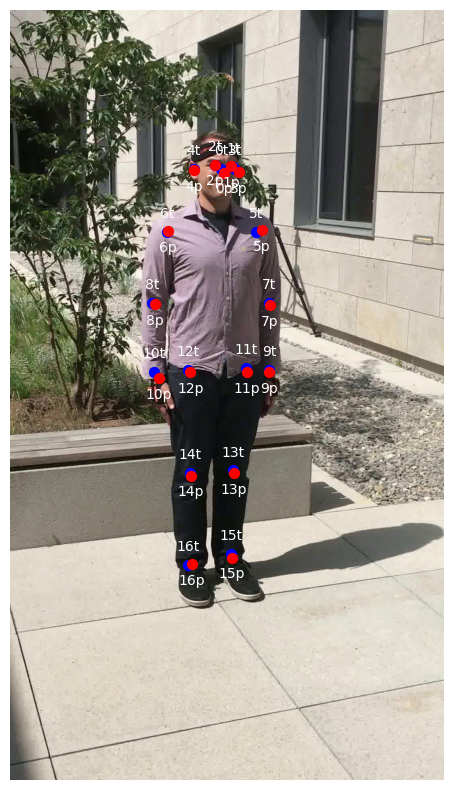

In [75]:
plot_keypoints_on_frame(path_to_video, joint_dict[f'{sequence_name}.mp4'], postitional_data[f'{sequence_name}.mp4']['custom'][0])

In [56]:
#calculate average distance
def compute_average_distances(ground_truths, pred_keypoints):
    num_videos = len(ground_truths)
    num_keypoints = ground_truths[0].shape[1]  # Assuming all keypoint arrays have the same shape

    distances_sum = np.zeros(num_keypoints)
    total_frames = 0

    for video_idx in range(num_videos):
        gt_video = ground_truths[video_idx]
        pred_video = pred_keypoints[video_idx]
        num_frames = gt_video.shape[0]

        for frame_idx in range(num_frames):
            gt_frame = gt_video[frame_idx]
            pred_frame = pred_video[frame_idx]
            distances = np.sqrt(np.sum((pred_frame - gt_frame)**2, axis=1))
            distances_sum += distances

        distances_sum /= num_frames

    average_distances = distances_sum / num_videos
    return average_distances

In [82]:
average_distances = compute_average_distances(ground_truths, pred_keypoints)
print("Average distances for each keypoint:", average_distances)

Average distances for each keypoint: [ 9.95646542 11.22481141 65.41239596  2.49571063 54.76458806  4.23225736
  5.45457159  5.64541717 22.97956458  7.6763594  33.86335843  2.86914781
  3.39376237  9.43230412 11.77909442 13.79735534 16.41836119]


In [64]:
import cv2
import numpy as np
import os

def plot_keypoints_on_video(video_path, truth_keypoints, predicted_keypoints, average_distances):
    output_dir = '/content/output_videos'
    os.makedirs(output_dir, exist_ok=True)

    video_name = os.path.basename(video_path).split('.')[0]
    output_path = os.path.join(output_dir, f'{video_name}_output.mp4')

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count < len(truth_keypoints):
            for i, (gt, pred) in enumerate(zip(truth_keypoints[frame_count], predicted_keypoints[frame_count])):
                if np.any(gt != 0):
                    dist = np.linalg.norm(gt - pred)
                    cv2.circle(frame, (int(gt[0]), int(gt[1])), 2, (0, 255, 255), -1)  # Plot the keypoint
                    if gt[0] != 0 and gt[1] != 0:
                        color = (0, 255, 0) if dist < average_distances[i] else (0, 0, 255)
                        cv2.circle(frame, (int(gt[0]), int(gt[1])), radius=max(5, int(dist)), color=color, thickness=2)  # Plot the circle around the keypoint

        out.write(frame)
        frame_count += 1

    cap.release()
    out.release()
    print(f'Video processing complete and saved to {output_path}')

def plot_keypoints_on_blank_canvas(video_path, truth_keypoints, predicted_keypoints, average_distances):
    output_dir = '/content/stickman_videos'
    os.makedirs(output_dir, exist_ok=True)

    video_name = os.path.basename(video_path).split('.')[0]
    output_path = os.path.join(output_dir, f'{video_name}_stickman.mp4')

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    connections = [
        (0, 1), (1, 3), (0, 2), (2, 4),
        (1, 5), (2, 6),
        (5, 6),
        (5, 7), (7, 9),
        (6, 8), (8, 10),
        (5, 11), (6, 12), (11, 12),
        (11, 13), (13, 15),
        (12, 14), (14, 16)
    ]

    frame_count = 0
    while frame_count < len(truth_keypoints):
        canvas = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)  # Blank canvas

        for start, end in connections:
            if frame_count < len(truth_keypoints) and np.all(truth_keypoints[frame_count][start]) and np.all(truth_keypoints[frame_count][end]):
                start_point = tuple(truth_keypoints[frame_count][start].astype(int))
                end_point = tuple(truth_keypoints[frame_count][end].astype(int))
                cv2.line(canvas, start_point, end_point, (255, 255, 0), 1)

        if frame_count < len(truth_keypoints):
            for i, (gt, pred) in enumerate(zip(truth_keypoints[frame_count], predicted_keypoints[frame_count])):
                if np.any(gt != 0):
                    cv2.circle(canvas, (int(gt[0]), int(gt[1])), 2, (0, 255, 255), -1)  # Plot the keypoint
                    if gt[0] != 0 and gt[1] != 0:
                        dist = np.linalg.norm(gt - pred)
                        color = (0, 255, 0) if dist < average_distances[i] else (0, 0, 255)
                        cv2.circle(canvas, (int(gt[0]), int(gt[1])), radius=max(5, int(dist)), color=color, thickness=2)  # Plot the circle around the keypoint

        out.write(canvas)
        frame_count += 1

    out.release()
    print(f'Video processing complete and saved to {output_path}')

In [77]:
video_path = path_to_video
truth_keypoints = np.array(joint_dict[f'{sequence_name}.mp4'])
predicted_keypoints = np.array(postitional_data[f'{sequence_name}.mp4']['custom'][0])

In [78]:
plot_keypoints_on_video(video_path, truth_keypoints, predicted_keypoints, average_distances)
plot_keypoints_on_blank_canvas(video_path, truth_keypoints, predicted_keypoints, average_distances)

Video processing complete and saved to /content/output_videos/courtyard_laceShoe_00_output.mp4
Video processing complete and saved to /content/stickman_videos/courtyard_laceShoe_00_stickman.mp4


In [79]:
print(truth_keypoints.shape)
print(predicted_keypoints.shape)

(931, 17, 2)
(931, 17, 2)


In [68]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
drive_dir = '/content/drive/My Drive/Colab Videos'

In [80]:
video1_path = f'/content/output_videos/{sequence_name}_output.mp4'
video2_path = f'/content/stickman_videos/{sequence_name}_stickman.mp4'

In [71]:
import shutil

In [81]:
shutil.move(video1_path, os.path.join(drive_dir, f'{sequence_name}_output'))
shutil.move(video2_path, os.path.join(drive_dir, f'{sequence_name}_stickman'))

'/content/drive/My Drive/Colab Videos/courtyard_laceShoe_00_stickman'